# Dependencies

In [54]:
# !pip install pandas
# !pip install transformers
# !pip install --upgrade jupyter ipywidgets
# !pip install torch torchvision torchaudio
# !pip install tensorflow
# !pip install flax
# !pip install evaluate

In [55]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import pipeline
from sklearn.metrics import classification_report, confusion_matrix, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from evaluate import load
import numpy as np

# Import data

In [56]:
data = pd.read_csv("dataset/small_data_sample.csv")
data

,text,label
0,"Explosion Rocks Baghdad Neighborhood BAGHDAD, ...",0
1,BBC reporters' log BBC correspondents record e...,0
2,Israel welcomes Rice nomination; Palestinians ...,0
3,Medical Journal Calls for a New Drug Watchdog ...,0
4,Militants Kidnap Relatives of Iraqi Minister-T...,0
...,...,...
39995,Microsoft Tests MSN Messenger 7.0 Updated chat...,3
39996,Vonage talks of 911 advancements In Rhode Isla...,3
39997,Exploring Venus: The Hothouse Planet Before sp...,3
39998,PayPal to Impose Fines for Breaking Bans - On...,3


---

In [57]:
# full dataset
data_full = pd.read_csv("dataset/training_data.csv")
data_full

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [58]:
dataset_hf = Dataset.from_pandas(data)
dataset_hf_full = Dataset.from_pandas(data_full)

In [59]:
# 80% train + validation, 20% test
train_test = dataset_hf.train_test_split(test_size=0.2, seed=42)
# Split the 80% train+validation set in 90% train, 10% validation
train_valid = train_test['train'].train_test_split(test_size=0.1)

test_set = set([item['text'] for item in train_test['test']])
# The remaining data will be the train and validation set
train_valid_indices = list(set(range(len(dataset_hf_full))) - test_set)
train_valid_set_full = dataset_hf_full.select(train_valid_indices)

# Now you can split the train and validation set as before
train_valid_full = train_valid_set_full.train_test_split(test_size=0.1)

train_valid_test_dataset = DatasetDict({
    'train': train_valid['train'],
    'test': train_test['test'],
    'validation': train_valid['test']
})

train_valid_test_dataset_full = DatasetDict({
    'train': train_valid_full['train'],
    'test': train_test['test'], # keep the same test set as the small dataset
    'validation': train_valid_full['test']
})


In [60]:
train_valid_test_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 28800
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 3200
    })
})

In [61]:
train_valid_test_dataset_full

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 108000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
})

---

| Model Label | Model Label Value | -> | Data Label | Data Label Value |
| -------- | -------- | -------- | -------- | -------- |
| 0 | Sports | -> | 1 | Sports |
| 1 | Arts, Culture, and Entertainment | -> | 0 | World |
| 2 | Business and Finance | -> | 2 | Business |
| 3 | Health and Wellness | -> | 0 | World |
| 4 | Lifestyle and Fashion | -> | 0 | World |
| 5 | Science and Technology | -> | 3 | Sci/Tech |
| 6 | Politics | -> | 0 | World |
| 7 | Crime | -> | 0 | World |

In [62]:
label_converter = {
    0: 1,
    1: 0,
    2: 2,
    3: 0,
    4: 0,
    5: 3,
    6: 0,
    7: 0
}

In [63]:
label_dict = {
    0: 'World', 
    1: 'Sports', 
    2: 'Business',
    3: 'Sci/Tech'
}

In [64]:
model_name = "dstefa/roberta-base_topic_classification_nyt_news"

predictions_dict = {
    "Sports": 1,
    "Arts, Culture, and Entertainment": 0,
    "Business and Finance": 2,
    "Health and Wellness": 0,
    "Lifestyle and Fashion": 0,
    "Science and Technology": 3,
    "Politics": 0,
    "Crime": 0
}

In [65]:
def print_metrics(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred, average='macro'))
    print('Recall: ', recall_score(y_test, y_pred, average='macro'))
    print('F1: ', f1_score(y_test, y_pred, average='macro'))

# Transformer Pipeline

In [66]:
classifier = pipeline(model=model_name)
classifier2 = pipeline(model=model_name)

## smaller data set

In [67]:
predictions = [classifier(row)[0]['label'] for row in train_valid_test_dataset['test']['text']]
converted_predictions = [predictions_dict[entry] for entry in predictions]
real_values = [int(actual_label) for actual_label in train_valid_test_dataset['test']['label']]
print(classification_report(real_values, converted_predictions))

KeyboardInterrupt: 

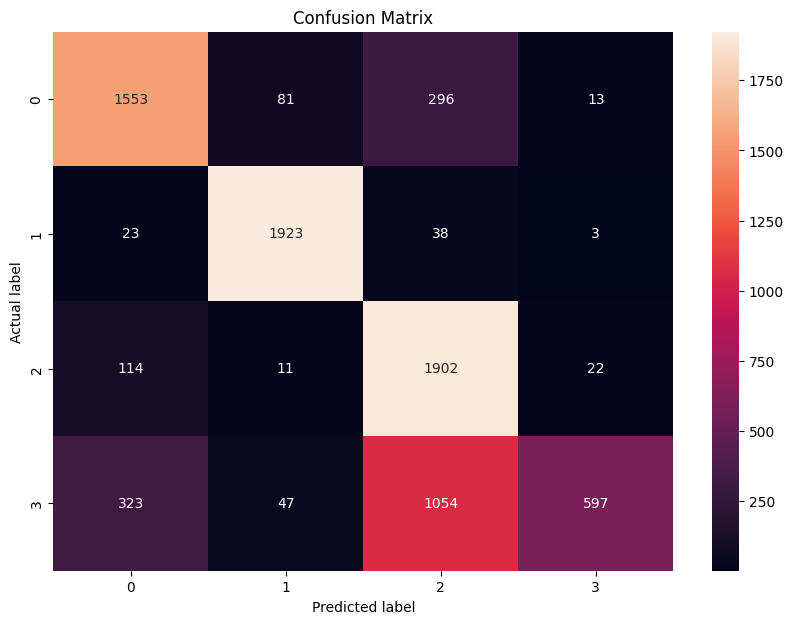

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(real_values, converted_predictions)

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Fine-tuning 

## Tokenize dataset

In [ ]:
# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

model2 = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:
def preprocess_function(sample):
    return tokenizer(sample["text"], truncation=True)

In [ ]:
tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)
tokenized_dataset

tokenized_dataset_full = train_valid_test_dataset_full.map(preprocess_function, batched=True)
tokenized_dataset_full

Map:   0%|          | 0/28800 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 108000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 12000
    })
})

## Finetune the model

In [77]:
metric = load("accuracy")

def compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    print(predictions)
    predictions_converted = [label_converter[entry] for entry in predictions]
    # print(predictions_converted)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=4
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer2 = Trainer(
    model=model2,
    args=training_args,
    train_dataset=tokenized_dataset_full["train"],
    eval_dataset=tokenized_dataset_full["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

## Smaller Dataset

In [ ]:
trainer.train()

  0%|          | 0/5400 [00:00<?, ?it/s]

{'loss': 0.5621, 'grad_norm': 8.004178047180176, 'learning_rate': 1.814814814814815e-05, 'epoch': 0.28}
{'loss': 0.3412, 'grad_norm': 1.8507068157196045, 'learning_rate': 1.6296296296296297e-05, 'epoch': 0.56}
{'loss': 0.3213, 'grad_norm': 2.722515106201172, 'learning_rate': 1.4444444444444446e-05, 'epoch': 0.83}


  0%|          | 0/200 [00:00<?, ?it/s]

[0 1 0 ... 1 1 3]
{'eval_loss': 0.31638777256011963, 'eval_accuracy': 0.8965625, 'eval_runtime': 6.1495, 'eval_samples_per_second': 520.366, 'eval_steps_per_second': 32.523, 'epoch': 1.0}
{'loss': 0.291, 'grad_norm': 0.5453465580940247, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}
{'loss': 0.2821, 'grad_norm': 2.977935552597046, 'learning_rate': 1.0740740740740742e-05, 'epoch': 1.39}
{'loss': 0.2541, 'grad_norm': 28.66678810119629, 'learning_rate': 8.888888888888888e-06, 'epoch': 1.67}
{'loss': 0.2538, 'grad_norm': 10.11005687713623, 'learning_rate': 7.0370370370370375e-06, 'epoch': 1.94}


  0%|          | 0/200 [00:00<?, ?it/s]

[0 1 0 ... 1 1 3]
{'eval_loss': 0.2876495122909546, 'eval_accuracy': 0.906875, 'eval_runtime': 6.167, 'eval_samples_per_second': 518.894, 'eval_steps_per_second': 32.431, 'epoch': 2.0}
{'loss': 0.2397, 'grad_norm': 11.699662208557129, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}
{'loss': 0.2205, 'grad_norm': 2.7631096839904785, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}
{'loss': 0.2078, 'grad_norm': 4.344791412353516, 'learning_rate': 1.4814814814814815e-06, 'epoch': 2.78}


  0%|          | 0/200 [00:00<?, ?it/s]

[0 1 0 ... 1 1 3]
{'eval_loss': 0.29592421650886536, 'eval_accuracy': 0.9103125, 'eval_runtime': 6.1802, 'eval_samples_per_second': 517.783, 'eval_steps_per_second': 32.361, 'epoch': 3.0}
{'train_runtime': 684.6612, 'train_samples_per_second': 126.194, 'train_steps_per_second': 7.887, 'train_loss': 0.2911026128133138, 'epoch': 3.0}


TrainOutput(global_step=5400, training_loss=0.2911026128133138, metrics={'train_runtime': 684.6612, 'train_samples_per_second': 126.194, 'train_steps_per_second': 7.887, 'total_flos': 3638503897129728.0, 'train_loss': 0.2911026128133138, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

  0%|          | 0/200 [00:00<?, ?it/s]

[0 1 0 ... 1 1 3]


{'eval_loss': 0.2876495122909546,
 'eval_accuracy': 0.906875,
 'eval_runtime': 6.1685,
 'eval_samples_per_second': 518.766,
 'eval_steps_per_second': 32.423,
 'epoch': 3.0}

In [ ]:
predictions = trainer.predict(test_dataset=tokenized_dataset["test"])
predictions

  0%|          | 0/500 [00:00<?, ?it/s]

[3 1 2 ... 2 3 3]


In [69]:
print(classification_report(real_values, predictions.predictions.argmax(-1)))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1943
           1       0.96      0.98      0.97      1987
           2       0.87      0.88      0.88      2049
           3       0.89      0.89      0.89      2021
           4       0.00      0.00      0.00         0

    accuracy                           0.91      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.91      0.91      0.91      8000



/home/lucas/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucas/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucas/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


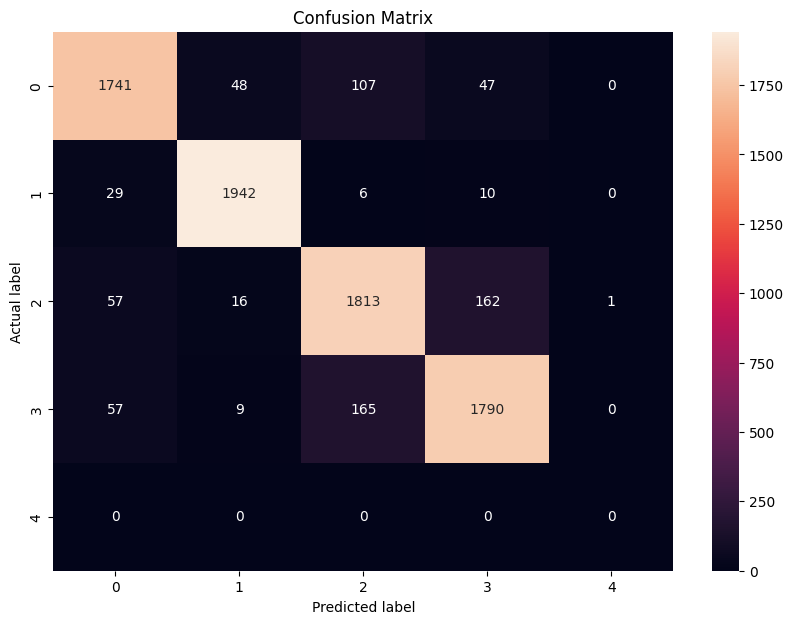

In [ ]:
# The predictions are in a tuple, with the first element being the actual predictions
predicted_labels = np.argmax(predictions[0], axis=1)

# Assuming the labels in your dataset are stored in a 'label' column
true_labels = [entry['label'] for entry in tokenized_dataset['test']]

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Full dataset

In [79]:
trainer2.train()

  0%|          | 0/10125 [00:00<?, ?it/s]

{'loss': 0.3539, 'grad_norm': 2.531465768814087, 'learning_rate': 1.901234567901235e-05, 'epoch': 0.15}
{'loss': 0.2937, 'grad_norm': 5.946872234344482, 'learning_rate': 1.802469135802469e-05, 'epoch': 0.3}
{'loss': 0.2809, 'grad_norm': 2.9198215007781982, 'learning_rate': 1.7037037037037038e-05, 'epoch': 0.44}
{'loss': 0.257, 'grad_norm': 3.047886371612549, 'learning_rate': 1.6049382716049385e-05, 'epoch': 0.59}
{'loss': 0.2518, 'grad_norm': 3.0332257747650146, 'learning_rate': 1.506172839506173e-05, 'epoch': 0.74}
{'loss': 0.2377, 'grad_norm': 1.7768771648406982, 'learning_rate': 1.4074074074074075e-05, 'epoch': 0.89}


  0%|          | 0/1500 [00:00<?, ?it/s]

[2 0 3 ... 3 0 2]
{'eval_loss': 0.21456003189086914, 'eval_accuracy': 0.927, 'eval_runtime': 24.8051, 'eval_samples_per_second': 483.771, 'eval_steps_per_second': 60.471, 'epoch': 1.0}
{'loss': 0.2187, 'grad_norm': 1.4993473291397095, 'learning_rate': 1.3086419753086422e-05, 'epoch': 1.04}
{'loss': 0.1828, 'grad_norm': 8.194146156311035, 'learning_rate': 1.2098765432098767e-05, 'epoch': 1.19}
{'loss': 0.1989, 'grad_norm': 3.6465649604797363, 'learning_rate': 1.1111111111111113e-05, 'epoch': 1.33}
{'loss': 0.1832, 'grad_norm': 4.7699666023254395, 'learning_rate': 1.0123456790123458e-05, 'epoch': 1.48}
{'loss': 0.1874, 'grad_norm': 0.95061194896698, 'learning_rate': 9.135802469135803e-06, 'epoch': 1.63}
{'loss': 0.1883, 'grad_norm': 1.998350739479065, 'learning_rate': 8.148148148148148e-06, 'epoch': 1.78}
{'loss': 0.1899, 'grad_norm': 4.139340400695801, 'learning_rate': 7.160493827160494e-06, 'epoch': 1.93}


  0%|          | 0/1500 [00:00<?, ?it/s]

[2 0 3 ... 3 0 2]
{'eval_loss': 0.19800740480422974, 'eval_accuracy': 0.93675, 'eval_runtime': 25.7888, 'eval_samples_per_second': 465.317, 'eval_steps_per_second': 58.165, 'epoch': 2.0}
{'loss': 0.17, 'grad_norm': 8.329080581665039, 'learning_rate': 6.17283950617284e-06, 'epoch': 2.07}
{'loss': 0.1575, 'grad_norm': 4.46077823638916, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}
{'loss': 0.1663, 'grad_norm': 4.763736724853516, 'learning_rate': 4.197530864197531e-06, 'epoch': 2.37}
{'loss': 0.166, 'grad_norm': 2.5719969272613525, 'learning_rate': 3.2098765432098767e-06, 'epoch': 2.52}
{'loss': 0.1577, 'grad_norm': 5.562180042266846, 'learning_rate': 2.222222222222222e-06, 'epoch': 2.67}
{'loss': 0.1555, 'grad_norm': 2.04240345954895, 'learning_rate': 1.234567901234568e-06, 'epoch': 2.81}
{'loss': 0.1535, 'grad_norm': 5.0920305252075195, 'learning_rate': 2.469135802469136e-07, 'epoch': 2.96}


  0%|          | 0/1500 [00:00<?, ?it/s]

[2 0 3 ... 3 0 2]
{'eval_loss': 0.19642183184623718, 'eval_accuracy': 0.938, 'eval_runtime': 24.899, 'eval_samples_per_second': 481.948, 'eval_steps_per_second': 60.243, 'epoch': 3.0}
{'train_runtime': 2548.8285, 'train_samples_per_second': 127.117, 'train_steps_per_second': 3.972, 'train_loss': 0.20670367205584492, 'epoch': 3.0}


TrainOutput(global_step=10125, training_loss=0.20670367205584492, metrics={'train_runtime': 2548.8285, 'train_samples_per_second': 127.117, 'train_steps_per_second': 3.972, 'total_flos': 1.386593900186688e+16, 'train_loss': 0.20670367205584492, 'epoch': 3.0})

In [80]:
trainer2.evaluate()

  0%|          | 0/1500 [00:00<?, ?it/s]

[2 0 3 ... 3 0 2]


{'eval_loss': 0.19642183184623718,
 'eval_accuracy': 0.938,
 'eval_runtime': 24.6851,
 'eval_samples_per_second': 486.124,
 'eval_steps_per_second': 60.765,
 'epoch': 3.0}

In [81]:
predictions = trainer2.predict(test_dataset=tokenized_dataset_full["test"]) 
predictions

  0%|          | 0/1000 [00:00<?, ?it/s]

[2 1 0 ... 2 2 3]


PredictionOutput(predictions=array([[-1.0156664 , -2.8910348 ,  5.283027  , ..., -7.791416  ,
        -7.2997866 , -8.918826  ],
       [-0.69255775,  8.173204  , -1.117244  , ..., -2.967994  ,
        -2.6750324 , -3.9161444 ],
       [ 7.593893  , -1.6737136 , -0.5768626 , ..., -5.204712  ,
        -5.4962726 , -6.170184  ],
       ...,
       [-0.5433234 , -2.5070581 ,  5.486241  , ..., -7.8499994 ,
        -7.942073  , -9.293407  ],
       [-0.6922522 , -2.686243  ,  4.8184485 , ..., -8.523465  ,
        -7.779453  , -9.438802  ],
       [-0.32865813, -2.9952898 ,  2.1106637 , ..., -8.097631  ,
        -7.2384877 , -8.791864  ]], dtype=float32), label_ids=array([2, 1, 0, ..., 2, 2, 3]), metrics={'test_loss': 0.1947629749774933, 'test_accuracy': 0.942875, 'test_runtime': 14.8992, 'test_samples_per_second': 536.943, 'test_steps_per_second': 67.118})

In [82]:
print(classification_report(real_values, predictions.predictions.argmax(-1)))

              precision    recall  f1-score   support

           0       0.98      0.92      0.94      1943
           1       0.98      0.99      0.99      1987
           2       0.90      0.92      0.91      2049
           3       0.92      0.94      0.93      2021
           6       0.00      0.00      0.00         0

    accuracy                           0.94      8000
   macro avg       0.76      0.75      0.75      8000
weighted avg       0.94      0.94      0.94      8000



/home/lucas/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucas/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucas/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


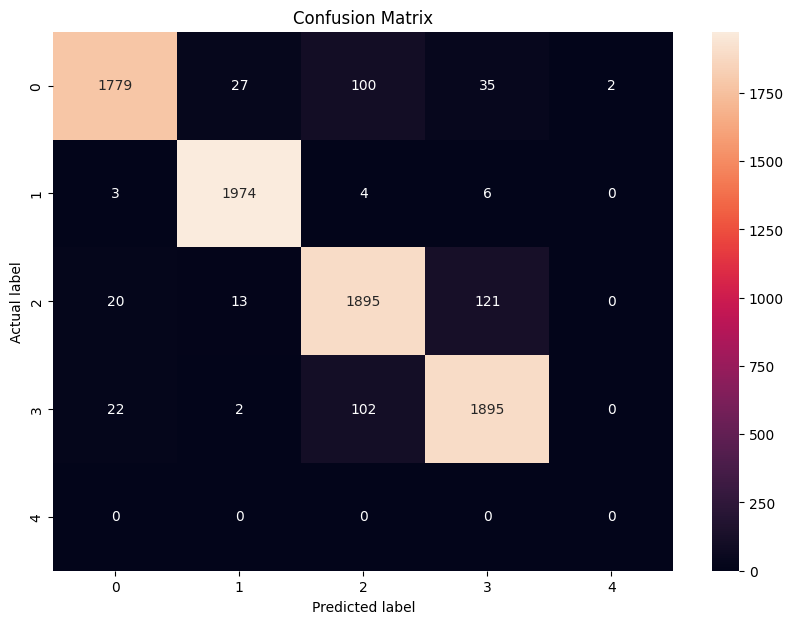

In [83]:
# The predictions are in a tuple, with the first element being the actual predictions
predicted_labels = np.argmax(predictions[0], axis=1)

# Assuming the labels in your dataset are stored in a 'label' column
true_labels = [entry['label'] for entry in tokenized_dataset_full['test']]

cm = confusion_matrix(true_labels, predicted_labels)

# Plot the heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Save the models

In [84]:
trainer.save_model()